In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast
from scipy.signal import savgol_filter
import utils

In [2]:
data_path = "../data"

In [3]:
measures = pd.read_csv(os.path.join(data_path, "measures.csv"), index_col=["subj_id", "session", "route", "intersection_no"])
processed_data = pd.read_csv(os.path.join(data_path, "processed_data.csv"), index_col=["subj_id", "session", "route", "intersection_no"])

In [63]:
condition_map = utils.get_nudge_condition_map()
conditions = condition_map.values()

In [4]:
len(measures.index.get_level_values("subj_id").unique())

19

In [90]:
def plot_traj(traj, traj_id):
    idx_truck_moving = traj.truck_v.to_numpy().nonzero()[0][0]
    idx_bot_moving = traj.bot_v.to_numpy().nonzero()[0][0]
    idx_bot_visible = idx_bot_moving + np.argmax(traj.bot_angle[idx_bot_moving:] - traj.truck_angle[idx_bot_moving:] < 0)

    fig, axes = plt.subplots(5, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t[idx_truck_moving:], traj.ego_v[idx_truck_moving:], color="C0")
    axes[0].plot(traj.t[idx_truck_moving], traj.ego_v[idx_truck_moving], color="C7", ls="", marker="o")
    axes[0].plot(traj.t[idx_bot_moving], traj.ego_v[idx_bot_moving], color="C7", ls="", marker="s")
    axes[0].plot(traj.t[idx_bot_visible], traj.ego_v[idx_bot_visible], color="C7", ls="", marker="x")
    axes[0].set_ylabel("ego v")

    axes[1].plot(traj.t[idx_truck_moving:], traj.throttle[idx_truck_moving:], color="C1")
    axes[1].plot(traj.t[idx_truck_moving], traj.throttle[idx_truck_moving], color="C7", ls="", marker="o")
    axes[1].plot(traj.t[idx_bot_moving], traj.throttle[idx_bot_moving], color="C7", ls="", marker="s")
    axes[1].plot(traj.t[idx_bot_visible], traj.throttle[idx_bot_visible], color="C7", ls="", marker="x")
    axes[1].set_ylabel("ego throttle")

    axes[2].plot(traj.t[idx_truck_moving:], traj.d_ego_bot[idx_truck_moving:], color="C2")
    axes[2].plot(traj.t[idx_truck_moving], traj.d_ego_bot[idx_truck_moving], color="C7", ls="", marker="o")
    axes[2].plot(traj.t[idx_bot_moving], traj.d_ego_bot[idx_bot_moving], color="C7", ls="", marker="s")
    axes[2].plot(traj.t[idx_bot_visible], traj.d_ego_bot[idx_bot_visible], color="C7", ls="", marker="x")
    axes[2].set_ylabel("d(ego to bot)")

    axes[3].plot(traj.t[idx_truck_moving:], traj.tta[idx_truck_moving:], color="C3")
    axes[3].plot(traj.t[idx_truck_moving], traj.tta[idx_truck_moving], color="C7", ls="", marker="o",
                 label="Truck starts moving")
    axes[3].plot(traj.t[idx_bot_moving], traj.tta[idx_bot_moving], color="C7", ls="", marker="s",
                 label="Bot starts moving")
    axes[3].plot(traj.t[idx_bot_visible], traj.tta[idx_bot_visible], color="C7", ls="", marker="x",
                 label="Bot visible")
    axes[3].axhline(4.5, color="grey", ls="--")
    axes[3].axhline(5.5, color="grey", ls="--")
    axes[3].set_ylabel("tta")
    # axes[3].set_ylim((0, 7))

    axes[4].plot(traj.t[idx_truck_moving:], traj.bot_v[idx_truck_moving:], color="C6")
    axes[4].plot(traj.t[idx_bot_visible], traj.bot_v[idx_bot_visible], ls="", marker="x", color="C7")
    axes[4].set_ylabel("bot v")

    # plt.plot(traj.t[idx_bot_moving:], traj.bot_angle[idx_bot_moving:]-traj.truck_angle[idx_bot_moving:])
    # plt.plot(traj.t[idx_bot_visible], traj.bot_angle[idx_bot_visible]-traj.truck_angle[idx_bot_moving+idx_bot_visible], marker='o')
    # plt.axhline(0.0, color="grey", ls="--")
    #
    # axes[5].plot(traj.t, traj.bot_angle, label="visual angle to the bot")
    # axes[5].plot(traj.t, traj.truck_angle, label="visual angle to the edge of the truck")
    # axes[5].plot(traj.t[idx_truck_moving:], traj.truck_angle[idx_truck_moving:], color="C4", label="Ego-truck angle")
    # axes[5].plot(traj.t[idx_truck_moving:], traj.bot_angle[idx_truck_moving:], color="C5", label="Ego-bot angle")
    # axes[5].legend()
    # axes[5].set_ylim((-0.1, 0.1))

    axes[-1].set_xlabel("time $t$")

    legend = fig.legend(loc="upper left", bbox_to_anchor=(1.0, 0.9), title=str(traj_id))
    legend.get_title().set_fontsize("18")
    plt.tight_layout()

    return fig, axes

Some participants apparently defaulted to "open-loop" behavior - stop behind the truck, then take the turn without considering the oncoming car. This means they didn't really make gap acceptance decisions so we'll probably need to exclude those

(642, 1, 1, 26)


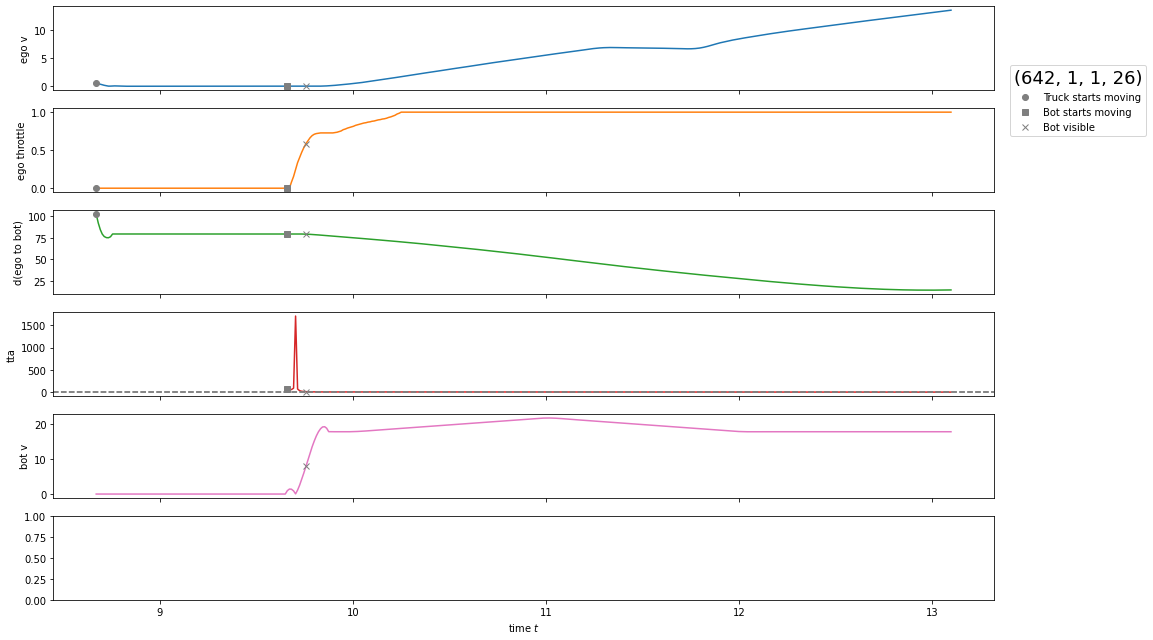

In [89]:
# normal trajectory
# traj_id = (200, 1, 1, 4)

# traj_id = random.choice(measures[(measures.RT>0.0) & (measures.RT<0.1) & (measures.is_go_decision)].index)
print(traj_id)
traj = processed_data.loc[traj_id].reset_index()
plot_traj(traj, traj_id);

In [66]:
def get_early_response_rate(subj_measures):
    return len(subj_measures[np.isnan(measures.RT) & (measures.is_go_decision)]) / len(subj_measures[subj_measures.is_go_decision])

print(measures.groupby("subj_id").apply(get_early_response_rate))

subj_id
138    0.099448
189    0.009434
200    0.391304
271    0.126214
295    0.000000
343    0.022222
390    0.000000
425    0.036697
450    0.033333
542    0.566138
543    0.943820
576    0.276596
642    0.079365
697    0.060811
746    0.795455
752    0.000000
774    0.071429
946    0.192053
990    0.000000
dtype: float64


C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_1552\1176200881.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return len(subj_measures[np.isnan(measures.RT) & (measures.is_go_decision)]) / len(subj_measures[subj_measures.is_go_decision])


In [67]:
print(measures.groupby("subj_id").apply(lambda m: len(m[m.is_go_decision]) / len(m)))

subj_id
138    0.905
189    0.530
200    0.805
271    0.515
295    0.065
343    0.225
390    0.235
425    0.545
450    0.300
542    0.945
543    0.890
576    0.235
642    0.630
697    0.740
746    0.880
752    0.115
774    0.070
946    0.755
990    0.090
dtype: float64


D:\source\cognitive-av\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Probability of go')

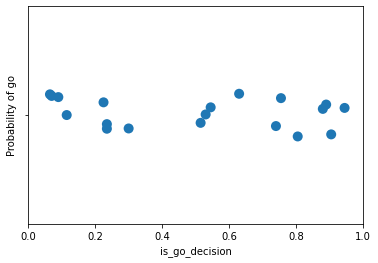

In [68]:
ax = sns.stripplot(measures.groupby("subj_id").is_go_decision.mean(), size=10)
ax.set_xlim((0,1))
ax.set_ylabel("Probability of go")

In [70]:
p_go_subj = measures.groupby("subj_id").is_go_decision.mean()

In [73]:
p_go_subj[(p_go_subj<0.1) | (p_go_subj>0.9)]

subj_id
138    0.905
295    0.065
542    0.945
774    0.070
990    0.090
Name: is_go_decision, dtype: float64

# Response times

Proportion of stay trials with missing RT

In [54]:
len(measures[(measures.RT<=0) & ~measures.is_go_decision])/len(measures[~measures.is_go_decision])

0.0

<AxesSubplot: >

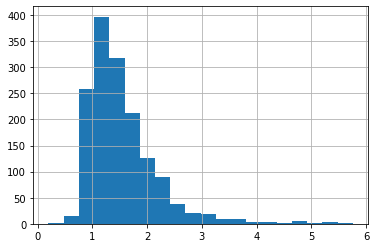

In [55]:
measures[~measures.is_go_decision].RT.hist(bins=20)

Proportion of go trials with premature response

In [58]:
len(measures[(measures.RT==0) & measures.is_go_decision])

145

In [56]:
len(measures[(measures.RT==0) & measures.is_go_decision])/len(measures[measures.is_go_decision])

0.13110307414104883

<AxesSubplot: >

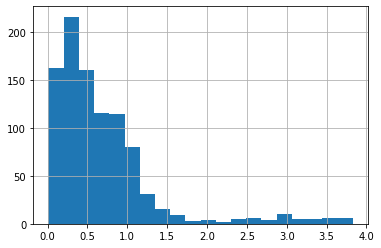

In [57]:
measures[measures.is_go_decision & (measures.RT>0)].RT.hist(bins=20)

# Changes of mind

In [31]:
measures[measures.is_go_decision & (measures.RT_yield>0)].groupby("a_values").size()

a_values
(0.0, -4, -4, 0.0)    47
(0.0, -4, 4, 0.0)      2
(0.0, 4, -4, 0.0)      2
dtype: int64

In [32]:
print(measures[~(measures.is_go_decision) & (measures.RT_yield>measures.RT_gas)].reset_index().groupby("subj_id").size())

subj_id
189    21
200    28
271    60
295    24
343    53
390    15
425    59
450    34
576    64
642    47
697    38
752     2
946    42
990     4
dtype: int64


# Measure plots

In [34]:
measures = measures.reset_index()

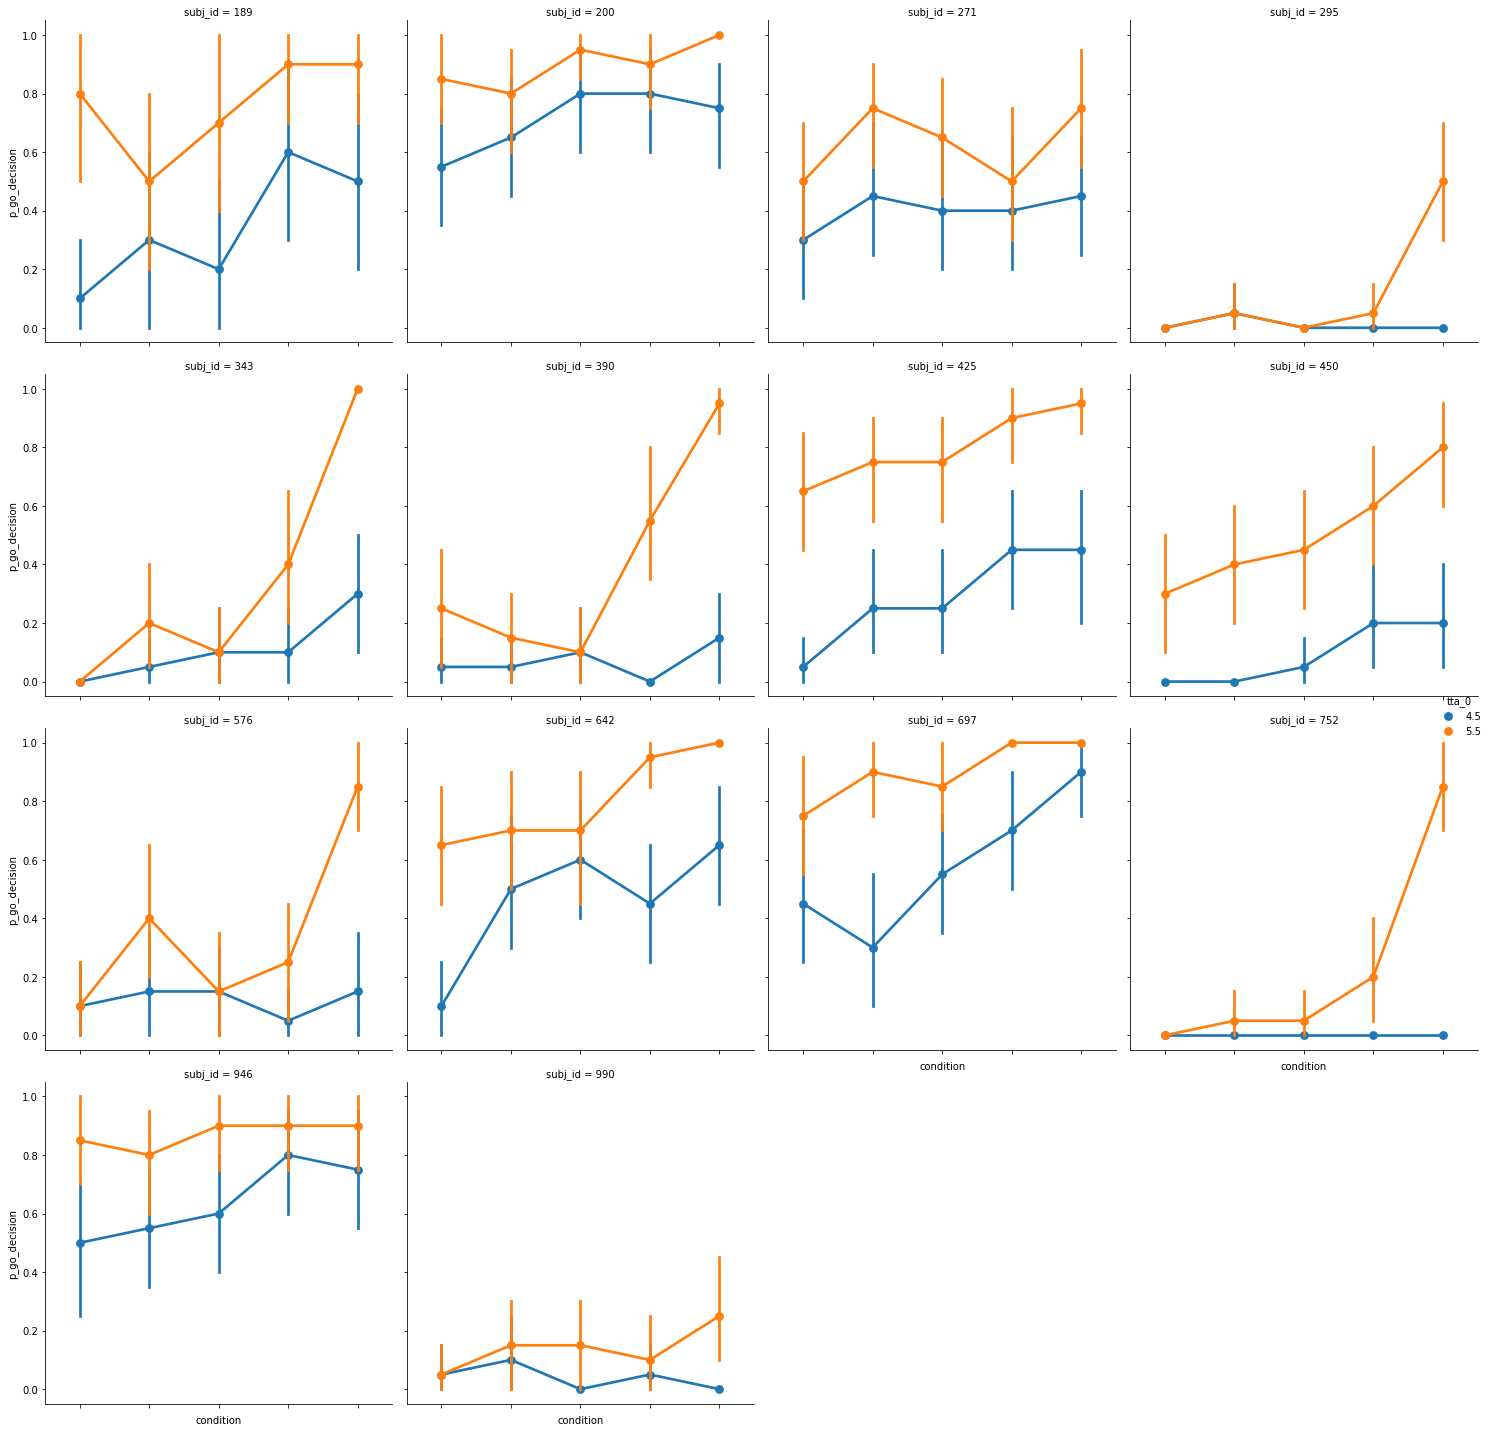

In [39]:
g = sns.catplot(data=measures, x="condition", y="p_go_decision", hue="tta_0", col="subj_id", col_wrap=4, kind="point",
            order=conditions)
for ax in g.axes:
    # for ax in axes:
    # ax.set_ylim((-0.05, 1.05))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("../figures/p_go.png")

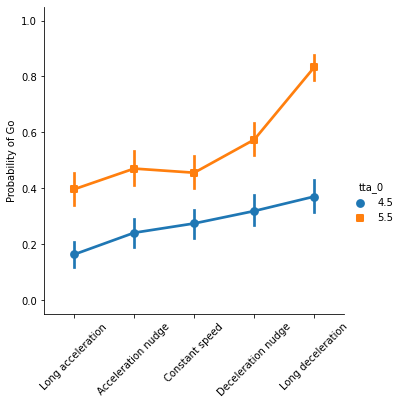

In [41]:
g = sns.catplot(data=measures, x="condition", y="p_go_decision", hue="tta_0", markers=["o", "s"],# col="tta_condition",
                kind="point", order=conditions)

for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_xlabel("")
        ax.set_ylabel("Probability of Go")

# Response times

2100


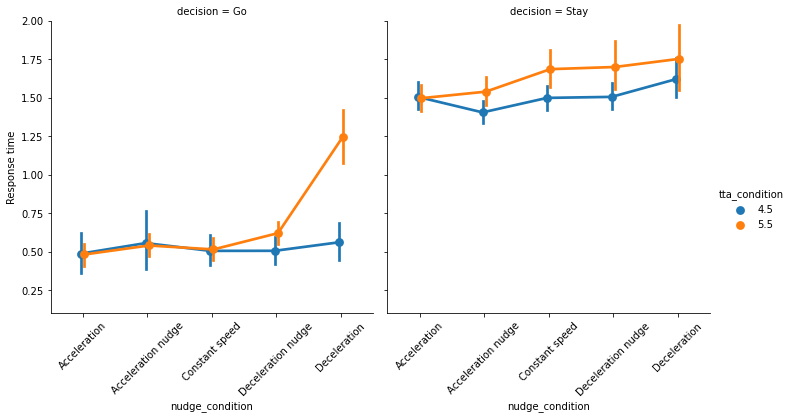

In [178]:
# Plot all RTs
data = measures

# Excluding stay->go changes-of-mind (almost exclusively observed in the deceleration condition)
# data = measures.copy()
# data.loc[(data.is_go_decision) & (data.RT_yield > 0), "RT"] = data[(data.is_go_decision) & (data.RT_yield > 0)].RT_yield

print(len(data))
g = sns.catplot(data=data[data.RT>0], x="nudge_condition", y="RT", hue="tta_condition", col="decision",
                kind="point", dodge=True,
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])

for axes in g.axes:
    for ax in axes:
        ax.set_ylim((0.1, 2.0))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Response time")

# Subjective ratings

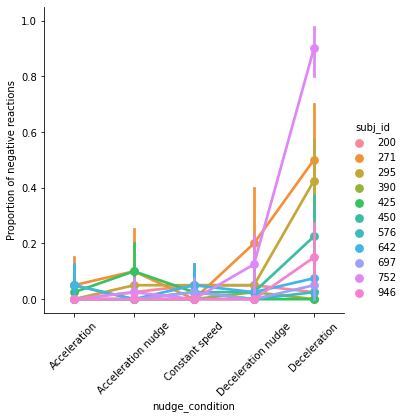

In [179]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", kind="point", hue="subj_id",
               order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])

for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")


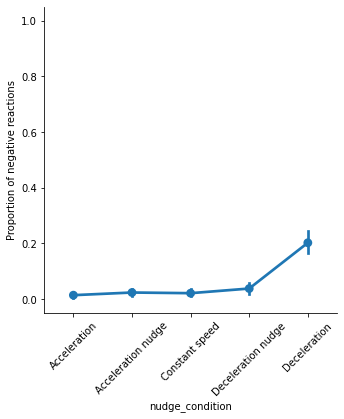

In [180]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")

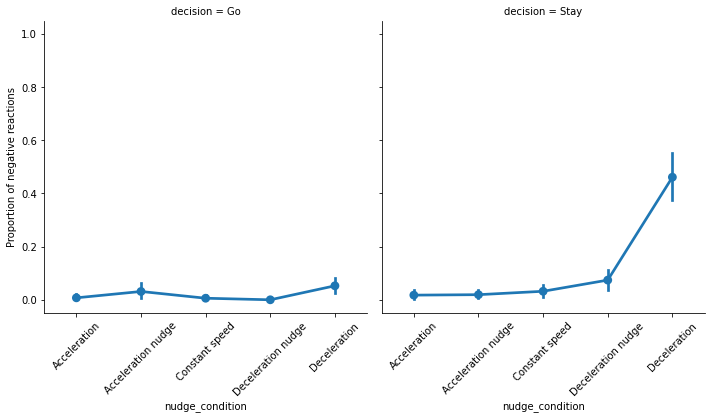

In [181]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", col="decision", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")